# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# RAMP on variable star type prediction

<i> Balázs Kégl (LAL/CNRS), Marc Moniez (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

<h1>Introduction</h1>

<h3>Variable stars</h3>

Most stars emit light steadily in time, but a small fraction of them has a variable <i>light curve</i>: light emission versus time. We call them <a href = "http://en.wikipedia.org/wiki/Variable_star">variable stars</a>. The light curves are usually <a href="http://en.wikipedia.org/wiki/Periodic_function">periodic</a> and highly regular. There are essentially two reasons why light emission can vary. First, the star itself can be <a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">oscillating</a>, so its light emission varies in time. Second, the star that seems a single point at Earth (because of our large distance) is actually a <a href="http://en.wikipedia.org/wiki/Binary_system"><i>binary system</i></a>: two stars that <a href="https://www.youtube.com/watch?v=1kFFwHkxBiI">orbit around their common center of gravity</a>. When the <a href="http://en.wikipedia.org/wiki/Orbital_plane_%28astronomy%29">orbital plane</a> is parallel to our line of view, the stars <a href="http://csep10.phys.utk.edu/astr162/lect/binaries/eclipsing.html">eclipse each other</a> periodically, creating a light curve with a <a href="http://www.dlr.de/en/desktopdefault.aspx/tabid-5170/8702_read-20474/">charateristic signature</a>. Identifying, classifying, and analyzing variable stars are hugely important for calibrating distances, and making these analyses automatic will be crucial in the upcoming sky survey projects such as <a href="http://www.lsst.org/lsst/">LSST</a>.

<h3>The EROS1 database, a catalog of light curves</h3> 

Our data is coming from the <a href="http://eros.in2p3.fr/">EROS1 project</a> that took data between 1990 and 1994.
400 <a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/photometry_photographicastro.html">photographic plates</a> were taken of the <a href="http://en.wikipedia.org/wiki/Large_Magellanic_Cloud">Large Magellanic Cloud</a> with the <a href="http://www.eso.org/public/teles-instr/lasilla/1mschmidt/">ESO-Schmidt 1m telescope</a>. Each plate covers the same $5^\circ \times 5^\circ$ field, centered at $\alpha  = 5h18m43s$, $\delta = −69d42m17s$ in the <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">celestial coordinate system</a>. Photos were taken in two <a href = "http://science-edu.larc.nasa.gov/EDDOCS/Wavelengths_for_Colors.html">frequency bands</a> (red: 630nm; blue: 385nm), digitized at the <a href="http://en.wikipedia.org/wiki/Paris_Observatory">Observatoire de Paris</a>, and analyzed at the <a href="http://cc.in2p3.fr/">IN2P3 Computing Center</a>.

<h3>Selecting variable stars</h3>

The full catalog contains 8 million objects. We estimated the probability of a star being stable using an in-house algorithm and selected the $\simeq 1\%$ least stable stars. The light curve of each selected star was then visually inspected, and the star was either declared stable or assigned a variability type and a quality index. The variability types are <a href="http://en.wikipedia.org/wiki/Binary_star#Eclipsing_binaries">eclipsing binary</a>, <a href="http://en.wikipedia.org/wiki/Cepheid_variable">Cepheid</a>, <a href="http://en.wikipedia.org/wiki/RR_Lyrae_variable">RR-Lyrae</a>, <a href="http://en.wikipedia.org/wiki/Mira_variable">Mira</a>, and other (the variability is clearly established, but the type is unclear). The quality index was visually estimated from 1 (lowest signal to background ratio) to 3 (best signal to background ratio). A total of 22802 variable objects were found that include 9046 RR-Lyrae, 2758 Cepheids, 1596 eclipsing binaries, 890 Miras, and 8512 unclassified objects. About 10% of the data was lost in the data archeology step that included converting the measurements from a native <a href="http://en.wikipedia.org/wiki/Physics_Analysis_Workstation">PAW</a> format to csv, giving us a total of 19429 stars.

<h3>Selecting data</h3>

For the RAMP, we decided to drop all instances in the "unclassified object" category since the interpretation of this type was unclear. We then randomly selected 30% of the data for public training, giving us 3641 training instances.

The data consists of two files, train.csv contains "static" features in a classical row-wise csv table, and train_varlength_features.csv.gz is a table that contains all the time series. The contents and the format of both files are explained below.

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
pd.set_option('display.max_columns', None)

## Fetch the data and load it in pandas

In [2]:
data = pd.read_csv("public_train.csv", index_col=0)

In [3]:
data.shape

(3641, 23)

## The static features

<span style="color:red">Red variables</span> are ids, labels, or other human-annotated features, so they should not be used as input in the classification. <span style="color:lightblue">Light blue variables</span> are legal but not likely to contribute information to the classification. Black variables are definitely discriminative.

<ul>
    <li> <code><b><span style="color:red">patch_id</span></b></code>: The catalogue is organized by tiles corresponding to $1$cm$^2$ patches on the plates, this is their id.
    <li> <code><b><span style="color:red">star_id_b, star_id_r</span></b></code>: The id of the star within the patch. <code>patch_id</code> and <code>star_id_b</code> or <code>star_id_r</code> identify the stars uniquely, and we use <code>[patch_id]_[star_id_b]</code> for indexing the stars in the pandas table.
    <li> <code><b>magnitude_b, magnitude_r</b></code>: The average apparent luminosity of the star (in two frequency bands). <a href="http://www.astro-tom.com/technical_data/magnitude_scale.htm">Magnitude</a> is a logarithmic measure, and the higher it is, the lower the apparent luminosity is.
    <li> <code><b><span style="color:lightblue">asc_d, asc_m, asc_s</span></b></code>: <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">Celestial</a> <a href="http://en.wikipedia.org/wiki/Right_ascension">right ascension</a> (coordinate) of the star, measured in degrees, minutes, and seconds, respectively.
    <li> <code><b><span style="color:lightblue">dec_d, dec_m, dec_s</span></b></code>: <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">Celestial</a> <a href="http://en.wikipedia.org/wiki/Declination">declination</a> (coordinate) of the star, measured in degrees, minutes, and seconds, respectively.
    <li> <code><b><span style="color:black">period</span></b></code>: the estimated period of the light curve. For the correct period, it should be divided by <code>div_period</code>
    <li> <code><b><span style="color:lightblue">frequency</span></b></code>: $1/$<code>period</code>, so it is redundant.
    <li> <code><b><span style="color:lightblue">num_points_good_b, num_points_good_r</span></b></code>: Number of good light curve measurements (some measurements can be corrupted). 
    <li> <code><b><span style="color:black">asym_b, asym_r</span></b></code>: Unknown semantics.
    <li> <code><b><span style="color:black">log_p_not_variable</span></b></code>: Logarithm of the estimated probability that the star is stable.
    <li> <code><b><span style="color:black">sigma_flux_b, sigma_flux_r</span></b></code>: The square root of the total variance of the light measurements (indicating the amplitude of the variability).
    <li> <code><b><span style="color:red">type</span></b></code>: The label to predict.
    <li> <code><b><span style="color:red ">quality</span></b></code>: Human-annotated measure of the quality of the time curve. The higher the better.
    <li> <code><b><span style="color:black ">div_period</span></b></code>: The algorithm that estimates the <code>period</code> sometimes finds a multiple of the period. These cases were human-detected, and the divisor was recorded. In principle this variable is not available automatically as an observable, but we are confident that it could be obtained automatically, so we allow it as an input.
</ul> 

In [4]:
data.head()

,patch_id,star_id_b,star_id_r,magnitude_b,magnitude_r,asc_d,asc_m,asc_s,dec_d,dec_m,dec_s,period,frequency,num_points_good_b,num_points_good_r,asym_b,asym_r,log_p_not_variable,sigma_flux_b,sigma_flux_r,type,quality,div_period
54_3198,54,3198,3327,19.0780,18.1298,5,48,19.58,-70,36,16.84,0.610837,1.637100,123,122,2.617650,0.794118,-2.760590,41.4272,88.0977,3,2,1
578_2223,578,2223,2598,19.0282,18.8067,5,5,52.85,-69,8,40.12,1.913020,0.522734,119,120,1.125000,0.600000,-2.237330,39.5553,45.3581,3,2,6
242_3046,242,3046,3274,17.8534,15.6034,5,31,26.46,-69,14,32.21,0.996323,1.003690,102,97,1.372090,1.365850,-3.580450,118.8270,939.3540,3,1,1
183_521,183,521,484,19.5333,19.3503,5,36,22.17,-68,38,58.52,3.116680,0.320854,124,120,0.823529,0.518987,-1.928280,23.8917,26.5069,3,1,8
78_8616,78,8616,8899,19.3348,18.4437,5,45,26.50,-70,1,24.55,0.621602,1.608750,122,122,0.648649,1.000000,-0.007193,28.7311,66.2163,1,0,1


## The labels

In [5]:
labels = np.sort(data['type'].unique())
label_names = ['binary', 'cepheid', 'rr_lyrae', 'mira']
pd.DataFrame([labels, [data[data['type'] == label].shape[0] for label in labels]], 
             columns=label_names, 
             index=["labels", "num_instances"])

,binary,cepheid,rr_lyrae,mira
labels,1,2,3,4
num_instances,439,736,2231,235


## Some classwise histograms and scatterplots

In [6]:
colors = ['r', 'b', 'g', 'm']
def plot_classwise_normalized(feature, bins=[]):
    if bins == []:
        bins = np.linspace(data[feature].min(), data[feature].max(), 15)
    for label, color in zip(labels, colors):
        plt.hist(data[data['type'] == label][feature].values, normed=True, bins=bins, 
                 alpha = 0.5, color = color)

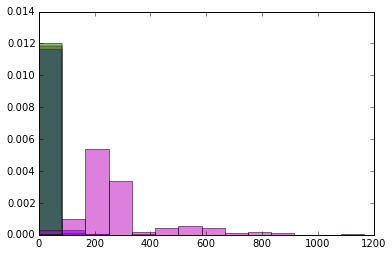

In [7]:
plot_classwise_normalized('period')

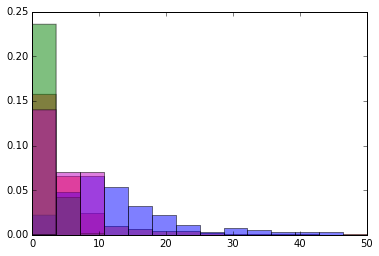

In [8]:
plot_classwise_normalized('period', bins=np.linspace(0, 50, 15))

Observe the aliasing below.

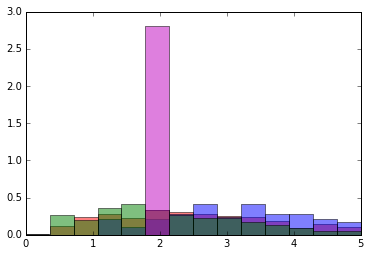

In [9]:
plot_classwise_normalized('period', bins=np.linspace(0, 5, 15))

In [10]:
data['real_period'] = data['period'] / data['div_period']

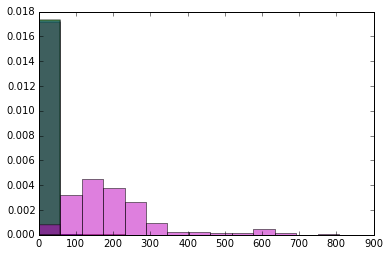

In [11]:
plot_classwise_normalized('real_period')

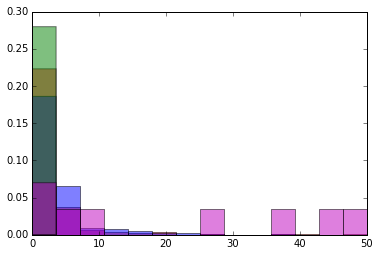

In [12]:
plot_classwise_normalized('real_period', bins=np.linspace(0, 50, 15))

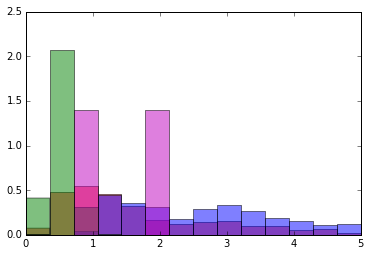

In [13]:
plot_classwise_normalized('real_period', bins=np.linspace(0, 5, 15))

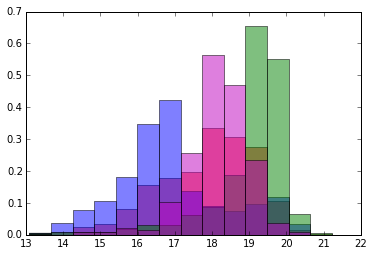

In [14]:
plot_classwise_normalized('magnitude_b')

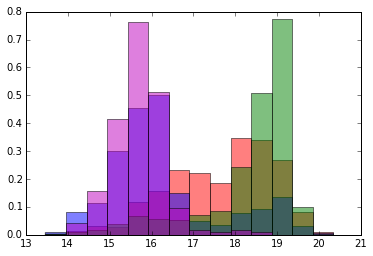

In [15]:
plot_classwise_normalized('magnitude_r')

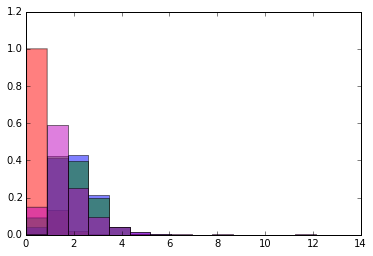

In [16]:
plot_classwise_normalized('asym_b')

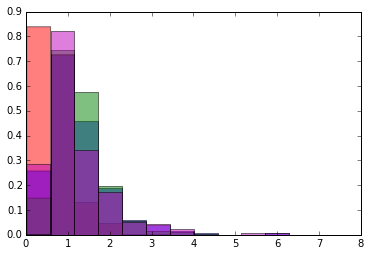

In [17]:
plot_classwise_normalized('asym_r')

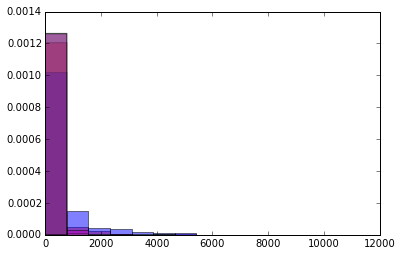

In [18]:
plot_classwise_normalized('sigma_flux_b')

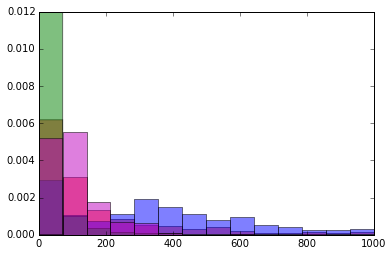

In [19]:
plot_classwise_normalized('sigma_flux_b', bins=np.linspace(0, 1000, 15))

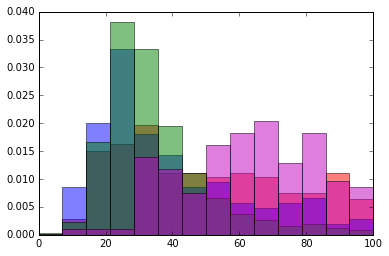

In [20]:
plot_classwise_normalized('sigma_flux_b', bins=np.linspace(0, 100, 15))

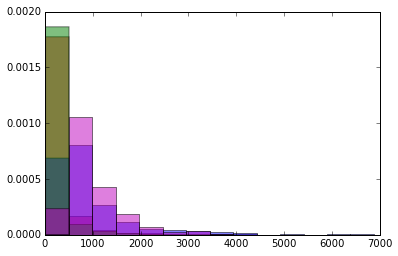

In [21]:
plot_classwise_normalized('sigma_flux_r')

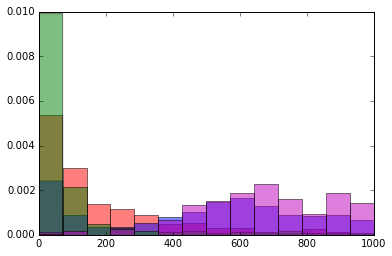

In [22]:
plot_classwise_normalized('sigma_flux_r', bins=np.linspace(0, 1000, 15))

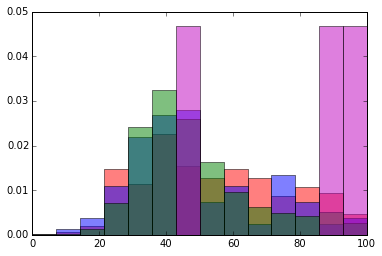

In [23]:
plot_classwise_normalized('sigma_flux_r', bins=np.linspace(0, 100, 15))

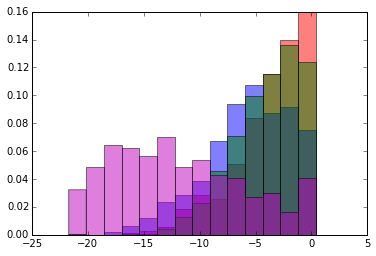

In [24]:
plot_classwise_normalized('log_p_not_variable')

In [25]:
colors = ['r', 'b', 'g', 'm']
def plot_classwise_scatter(feature1, feature2, range1=None, range2=None):
    if range1 == None:
        range1 = [data[feature1].min(), data[feature1].max()]
    if range2 == None:
        range2 = [data[feature2].min(), data[feature2].max()]
    for label, color in zip(labels, colors):
        plt.xlim(range1[0], range1[1])
        plt.ylim(range2[0], range2[1])
        plt.scatter(data[data['type'] == label][feature1], 
                    data[data['type'] == label][feature2],
            alpha=0.3, s=80, c=color, marker='.');

/Users/kegl/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


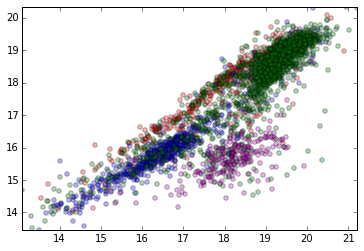

In [26]:
plot_classwise_scatter('magnitude_b', 'magnitude_r')

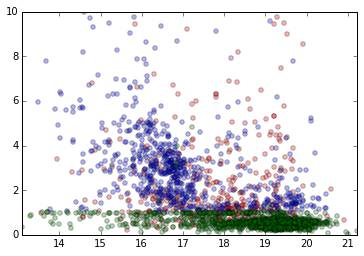

In [27]:
plot_classwise_scatter('magnitude_b', 'real_period', range1=None, range2=[0,10])

## The time series

In [28]:
def star_key(slab_id, star_id_b):
    return str(slab_id) + '_' + str(star_id_b)

def csv_array_to_float(csv_array_string):
    return map(float, csv_array_string[1:-1].split(","))

In [29]:
raw_time_series = pd.read_csv(
    "public_train_varlength_features.csv.gz", index_col=0, compression='gzip')
time_series = raw_time_series.applymap(csv_array_to_float)

The time series table contains ten time series per star: five of each frequency bands. Photos were taken once per night on selected days during a four-year period, measuring the majority of the stars about 120 times.

33.0
124.0
11.0
125.0


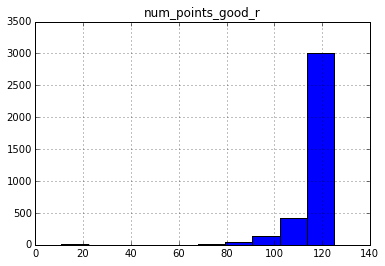

In [30]:
data.hist('num_points_good_r')
print(min(data['num_points_good_b']))
print(max(data['num_points_good_b']))
print(min(data['num_points_good_r']))
print(max(data['num_points_good_r']))

In [31]:
time_series.head()

,time_points_b,time_points_r,light_points_b,light_points_r,error_points_b,error_points_r,bkg_points_b,bkg_points_r,polltn_points_b,polltn_points_r
54_3198,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[18.71, 19.29, 19.27, 19.67, 19.68, 19.02, 18....","[17.96, 18.2, 18.06, 17.98, 18.11, 18.04, 18.1...","[0.12, 0.13, 0.12, 0.17, 0.23, 0.11, 0.11, 0.1...","[0.11, 0.16, 0.1, 0.1, 0.11, 0.15, 0.09, 0.09,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02, 0.08, 0.03, 0.05, 0.1, 0.05, 0.03, 0.03...","[0.02, 0.02, 0.02, 0.0, 0.02, 0.03, 0.0, 0.0, ..."
578_2223,"[290.3, 291.35, 322.25, 326.24, 345.18, 350.15...","[290.34, 291.31, 322.29, 347.17, 348.23, 353.1...","[19.12, 18.66, 18.94, 19.0, 19.0, 19.26, 19.27...","[18.54, 18.32, 18.52, 18.58, 18.95, 18.43, 18....","[0.15, 0.13, 0.16, 0.16, 0.17, 0.19, 0.15, 0.2...","[0.21, 0.24, 0.15, 0.28, 0.19, 0.14, 0.18, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.03, 0.03, 0.02, 0.02, 0.03, 0.06, 0.03, 0.0...","[0.02, 0.03, 0.0, 0.05, 0.02, 0.0, 0.02, 0.0, ..."
242_3046,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 322.29, 326.28, 347.17, 348.23, 353.1...","[17.78, 17.96, 17.88, 17.87, 17.82, 18.0, 17.6...","[15.63, 15.97, 15.97, 15.71, 15.72, 15.82, 15....","[0.1, 0.11, 0.08, 0.12, 0.12, 0.1, 0.11, 0.16,...","[0.12, 0.1, 0.1, 0.1, 0.07, 0.07, 0.07, 0.07, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0,..."
183_521,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[19.26, 19.77, 19.22, 19.67, 19.48, 19.43, 20....","[19.51, 19.16, 18.94, 19.16, 18.84, 19.55, 19....","[0.13, 0.2, 0.12, 0.16, 0.17, 0.14, 0.32, 0.19...","[0.3, 0.32, 0.16, 0.2, 0.16, 0.4, 0.23, 0.27, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0,...","[0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0....","[0.02, 0.06, 0.02, 0.03, 0.05, 0.05, 0.11, 0.0...","[0.35, 0.21, 0.1, 0.08, 0.08, 0.44, 0.08, 0.11..."
78_8616,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[19.36, 19.16, 19.74, 19.23, 19.5, 19.3, 19.58...","[18.46, 18.63, 18.49, 18.38, 18.62, 18.41, 18....","[0.14, 0.13, 0.18, 0.11, 0.18, 0.12, 0.18, 0.1...","[0.1, 0.19, 0.1, 0.1, 0.14, 0.16, 0.1, 0.09, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02, 0.02, 0.02, 0.0, 0.02, 0.02, 0.02, 0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Each column contains a list of floating point numbers.

<ul>
    <li> <code><b><span style="color:black">time_points_b, time_points_r</span></b></code>: The time (in unit of days) when the photos were taken. Note that the filters had to be changed so the time points of the blue and red frequency band are slighty different.
    <li> <code><b><span style="color:black">light_points_b, light_points_r</span></b></code>: The light points measured at the time points.
    <li> <code><b><span style="color:black">error_points_b, error_points_r</span></b></code>: Uncertainties (error bars) on the light measurements.
    <li> <code><b><span style="color:lightblue">bkg_points_, bkg_points_r</span></b></code>: Background noise measured at the time points.
    <li> <code><b><span style="color:lightblue">polltn_points_b, polltn_points_r</span></b></code>: Pollution noise measured at the time points.
</ul> 

### Plotting time curves

Set the patch id and star id below.

In [32]:
patch_id = 98
star_id_b = 477

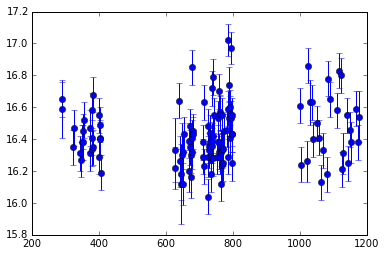

In [33]:
time_points = np.array(time_series.loc[star_key(patch_id, star_id_b)]['time_points_b'])
light_points = np.array(time_series.loc[star_key(patch_id, star_id_b)]['light_points_b'])
error_points = np.array(time_series.loc[star_key(patch_id, star_id_b)]['error_points_b'])
plt.errorbar(time_points, light_points, yerr=error_points, fmt='o');

The raw measurements seem rather messy. The scatter of the plots is visibly larger than the measurement uncertainty (which makes it, by definition, a variable star), but there is no visible periodicity. We can use the estimated period to overplot several periods of the curve ("fold" the time series) using the following function.

In [34]:
def fold_time_series(time_point, period, div_period):
    real_period = period / div_period
    return time_point % real_period  # modulo real_period

In [35]:
period = data.loc[star_key(patch_id, star_id_b)]['period']
div_period = data.loc[star_key(patch_id, star_id_b)]['div_period']
print period, div_period

1.41875 1.0


In [36]:
time_points_folded = np.array([fold_time_series(time_point, period, div_period) 
                      for time_point in time_points])

The resulting curve has a characteristic signature. 

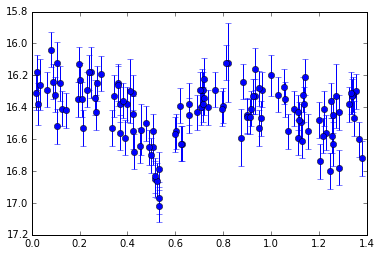

In [37]:
plt.gca().invert_yaxis()
plt.errorbar(time_points_folded, light_points, yerr=error_points, fmt='o');

#Submission

The goal of the RAMP is to classify the stars into one of the four types. In your code you will have access both to the static features and the time series. You will have to define two classes in two separate files. The submission site will have several examples that you can start from.

## The feature extractor

In <a href="https://drive.google.com/open?id=0BzwKr6zuOkdRdW8xWktSbVhTR1U&authuser=0"><code>feature_extractor.py</code></a> you will define a class called <code>FeatureExtractor</code>. Its main <code>transform</code> method takes a <b>list of dictionaries</b> and outputs a <b>numpy array</b>. Each dictionary of the list corresponds to one star. You can access features of that star using the notation <code>X_dict[i][feature_name]</code>, where <code>feature_name</code> can correspond to any of the features, both in <code>data</code> and <code>time_series</code>. In the following cell we transform our data files in this format, so you can access <code>X_dict</code> here and play with it.

In [38]:
def merge_two_dicts(x, y):
    '''Given two dicts, merge them into a new dict as a shallow copy.'''
    z = x.copy()
    z.update(y)
    return z

X_dict = data.drop('type', axis=1).to_dict(orient='records')
vf_dict = time_series.to_dict(orient='records')
X_dict = [merge_two_dicts(d_inst, v_inst) for d_inst, v_inst in zip(X_dict, vf_dict)]

In [39]:
X_dict[0]

{'asc_d': 5.0,
 'asc_m': 48.0,
 'asc_s': 19.579999999999998,
 'asym_b': 2.6176499999999998,
 'asym_r': 0.79411799999999999,
 'bkg_points_b': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]

In [40]:
X_dict[0]['magnitude_b']

19.077999999999999

The following cell gives you an example in which we extract some of the features from <code>X_dict</code> and convert it into a numpy array.

In [41]:
cols = [
    'magnitude_b', 
    'magnitude_r',
    'period',
    'asym_b', 
    'asym_r', 
    'log_p_not_variable', 
    'sigma_flux_b', 
    'sigma_flux_r', 
    'quality', 
    'div_period',
]
X_array = np.array([[instance[col] for col in cols] for instance in X_dict])

In [42]:
X_array

array([[  1.90780000e+01,   1.81298000e+01,   6.10837000e-01, ...,
          8.80977000e+01,   2.00000000e+00,   1.00000000e+00],
       [  1.90282000e+01,   1.88067000e+01,   1.91302000e+00, ...,
          4.53581000e+01,   2.00000000e+00,   6.00000000e+00],
       [  1.78534000e+01,   1.56034000e+01,   9.96323000e-01, ...,
          9.39354000e+02,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  2.00662000e+01,   1.96090000e+01,   7.44748000e-01, ...,
          2.20585000e+01,   0.00000000e+00,   1.00000000e+00],
       [  1.66903000e+01,   1.61105000e+01,   4.01878000e+00, ...,
          5.22704000e+02,   2.00000000e+00,   1.00000000e+00],
       [  1.48700000e+01,   1.53560000e+01,   3.02924000e+00, ...,
          1.22825000e+03,   0.00000000e+00,   3.00000000e+00]])

Finally, here is the full <a href="https://drive.google.com/open?id=0BzwKr6zuOkdRdW8xWktSbVhTR1U&authuser=0"><code>feature_extractor.py</code></a>. The transformation takes place in the <code>transform</code> function. If it does not depend on the training data (only the given instances to be transformed), this is all you have to fill out. If some operations depend on the training data (for example, you go for a PCA), it should be implemented in the <code>fit</code> function.

In [43]:
import numpy as np

class FeatureExtractor(object):

    def __init__(self):
        pass

    def fit(self, X_dict, y):
        pass

    def transform(self, X_dict):
        #print X_dict.keys()
        cols = [
            'magnitude_b',
            'magnitude_r',
            'period',
            'asym_b', 
            'asym_r', 
            'log_p_not_variable', 
            'sigma_flux_b', 
            'sigma_flux_r', 
            'quality', 
            'div_period',
        ]
        return np.array([[instance[col] for col in cols] for instance in X_dict])

The following feaure extractor does not use any of the static features. It takes the light curve, bins it into <code>num_bins</code> bins, and return the bin means (blue and red bands concatenated).

In [44]:
def fold_time_series(time_point, period, div_period):
    return time_point % (period / div_period)

def get_bin_means(instance, num_bins):
    period = instance['period']
    div_period = instance['div_period']
    real_period = period / div_period
    bins = [i * real_period / num_bins for i in range(num_bins + 1)]
    feature_array = np.empty(2 * num_bins)
    for band in ['b', 'r']:
        time_points = np.array(instance['time_points_' + band])
        light_points = np.array(instance['light_points_' + band])
        time_points_folded = np.array([fold_time_series(time_point, period, div_period) 
                                       for time_point in time_points])
        time_points_folded_digitized = np.digitize(time_points_folded, bins) - 1
        binned_means = np.array([light_points[time_points_folded_digitized == i].mean()
                                for i in range(num_bins)])
        if band == 'b':
            feature_array[:num_bins] = binned_means
        else:
            feature_array[num_bins:] = binned_means
    return feature_array

import numpy as np

class FeatureExtractor(object):

    def __init__(self):
        pass

    def fit(self, X_dict, y):
        pass

    def transform(self, X_dict):
        num_bins = 15
        return np.array([get_bin_means(instance, num_bins) for instance in X_dict])

This feature extractor combines bin means from the time series with three of the best static features.

In [45]:
def fold_time_series(time_point, period, div_period):
    return time_point % (period / div_period)

def get_bin_means(instance, num_bins):
    period = instance['period']
    div_period = instance['div_period']
    real_period = period / div_period
    bins = [i * real_period / num_bins for i in range(num_bins + 1)]
    feature_array = np.empty(2 * num_bins)
    for band in ['b', 'r']:
        time_points = np.array(instance['time_points_' + band])
        light_points = np.array(instance['light_points_' + band])
        time_points_folded = np.array([fold_time_series(time_point, period, div_period) 
                                       for time_point in time_points])
        time_points_folded_digitized = np.digitize(time_points_folded, bins) - 1
        binned_means = np.array([light_points[time_points_folded_digitized == i].mean()
                                for i in range(num_bins)])
        if band == 'b':
            feature_array[:num_bins] = binned_means
        else:
            feature_array[num_bins:] = binned_means
    return feature_array

import numpy as np

class FeatureExtractor(object):

    def __init__(self):
        pass

    def fit(self, X_dict, y):
        pass

    def transform(self, X_dict):
        cols = [
            'magnitude_b', 
            'magnitude_r'
        ]
        X_array = np.array([[instance[col] for col in cols] for instance in X_dict])
        real_period = np.array([instance['period'] / instance['div_period']
            for instance in X_dict])
        X_array = np.concatenate((X_array.T, [real_period])).T
        num_bins = 5
        X_array_variable_features = np.array([get_bin_means(instance, num_bins) for instance in X_dict])
        X_array = np.concatenate((X_array.T, X_array_variable_features.T)).T
        return X_array

## Classification

The classifier follows a classical scikit-learn classifier template. It should be placed in the file <a href="https://drive.google.com/open?id=0BzwKr6zuOkdRbXk1aTlQRll1dWc&authuser=0"><code>classifier.py</code></a>. In its simplest form it takes a scikit-learn pipeline and assignes it to <code>self.clf</code> in <code>__init__</code>.

In [46]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', Imputer(strategy='most_frequent')),
            ('rf', RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

## Calibration

The discriminant output $f(x): x \rightarrow R^k$ (<code>predict_proba</code>) of some classifiers is not consistent, which means that $f(x)_\ell \not\simeq p(y = \ell|x)$, even as the number of training points $n \rightarrow \infty$. At the same time they may be rank-consistent, that is, $f(x_1)_\ell > f(x_2)_\ell \Leftrightarrow p(y = \ell|x_1) > p(y = \ell|x_2)$. The usual way to make $f$ approximately consistent is to calibrate it, that is, regressing $f(x)$ to $p(x)$ using a monotonic regressor, then normalize the sum of $f(x)$. This usually does not change the classification accuracy (although in the multi-class $k>2$ case it may), but it makes the <code>predict_proba</code> better for ensembling, which means that it may improve your contributivity score. It also improves the score if it is not based on rank order, for example, in the case of binomial or multinomial likelihood).

See http://scikit-learn.org/stable/modules/calibration.html for more information on calibration.

The first "identity" calibrator below turns calibration off (returns the original output of <code>predict_proba</code>).

In [47]:
class Calibrator():
    def __init__(self):
        pass

    def fit(self, X_array, y_array):
        pass

    def predict_proba(self, y_probas_array_uncalibrated):
        return y_probas_array_uncalibrated

The second calibration (default in your sandbox) uses isotonic regression to calibrate the discriminant outputs.

In [48]:
import numpy as np
from sklearn.isotonic import IsotonicRegression


class Calibrator():
    def __init__(self):
        pass

    def fit(self, X_array, y_array):
        labels = np.sort(np.unique(y_array))
        self.calibrators = []
        for class_index in range(X_array.shape[1]):
            calibrator = IsotonicRegression(
                y_min=0., y_max=1., out_of_bounds='clip')
            class_indicator = np.array([1 if y == labels[class_index] else 0
                                        for y in y_array])
            calibrator.fit(X_array[:, class_index], class_indicator)
            self.calibrators.append(calibrator)

    def predict_proba(self, y_probas_array_uncalibrated):
        num_classes = y_probas_array_uncalibrated.shape[1]
        y_probas_array_transpose = np.array(
            [self.calibrators[class_index].predict(
                y_probas_array_uncalibrated[:, class_index])
             for class_index in range(num_classes)])
        sum_rows = np.sum(y_probas_array_transpose, axis=0)
        y_probas_array_normalized_transpose = np.divide(
            y_probas_array_transpose, sum_rows)
        return y_probas_array_normalized_transpose.T

## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>classifier.py</code>, <code>feature_extractor.py</code>, <code>calibrator.py</code>, and <code>user_test_model.py</code> in a directory, set the paths to the data files in <code>user_test_model.py</code>, and run 

<code>python user_test_model.py</code>

If it runs and prints 
<code>
Training file ...
accuracy = [some_number_between_0_and_1]
accuracy = [some_number_between_0_and_1]
</code>
you can submit the code.